# Exemplo de aplicação de Análise de Tráfego

Autoria: Igor Tibúrcio  
Orientação: Leonardo Hoinaski

## Introdução e Inicialização do módulo

Para fazer a análise de trânsito usando a arquitetura do LCQAr, precisaremos
usar dois pacotes exclusivos:
- TrafficServer: pacote para facilitar a obtenção e tratamento dos dados de 
tráfego e referência;
- TrafficData: pacote obtido a partir da função get_traffic_dataset

In [1]:
# Importings
import geopandas as gpd
from datetime import datetime
from trafficdata import TrafficServer
from trafficdata.core.package import get_traffic_dataset
from pathlib import Path
from pandas import Grouper
import pandas as pd
from trafficdata.core.trafficmeasurement import replace_min_plateau_using_gauss
from trafficdata import TrafficData  # importa a classe
import trafficdata

Para usar a estrutura de servidores via TrafficServer, precisamos indicar
o caminho da API dedicada para os dados de tráfego amostrados de forma horária,
em momentos aleatórios, e os dados do Geofabrik obtidos em 12 de maio de 2025.

In [2]:
# Data server paths
traffic_server_url = 'http://150.162.52.2:6140'              # Tomtom
reference_server_url = 'http://150.162.52.2:6150/2025_5_12'  # Geofabrik

Vamos também precisar de uma camada de máscara para facilitar nossa análise de
exemplo.  
  
Neste exemplo, vamos pegar uma pequena área que engloba estradas
entre Florianópolis (SC) e continente.

In [3]:
# Importing data mask example
mask = gpd.read_file('./inputs/floripa_sc.gpkg')
# mask['geometry'] = mask.unary_union.envelope
mask.explore()

Agora precisamos, instanciar e nos sincronizar com o servidor.

In [5]:
# Loading traffic server
ts = TrafficServer(
    traffic_server_url,
    reference_server_url
)

_ = ts.sync()

Synced!


Se quisermos, podemos avaliar os dados disponíveis por data e hora em UTM.

In [6]:
# List available datetime (UTM)
ts.list_available_dates()

2025-04-28: 22h–23h
2025-04-29: 00h–23h
2025-04-30: 00h–23h
2025-05-01: 00h–23h
2025-05-02: 00h–11h, 13h–23h
2025-05-03: 00h–23h
2025-05-04: 00h–23h
2025-05-05: 00h–23h
2025-05-06: 00h–13h, 15h–23h
2025-05-07: 00h–23h
2025-05-08: 00h–14h, 16h–23h
2025-05-09: 00h–14h, 16h–23h
2025-05-10: 00h–16h, 18h–23h
2025-05-11: 00h–23h
2025-05-12: 00h–23h
2025-05-13: 00h–23h
2025-05-14: 00h–04h, 06h–07h, 09h–13h, 19h–23h
2025-05-15: 00h–23h
2025-05-16: 00h–23h
2025-05-17: 00h–23h
2025-05-18: 00h–13h, 15h–23h
2025-05-19: 00h–23h
2025-05-20: 00h–09h, 11h–22h
2025-05-21: 13h–23h
2025-05-22: 00h–23h
2025-05-23: 00h–23h
2025-05-24: 00h–11h, 13h–23h
2025-05-25: 00h–23h
2025-05-26: 00h–23h
2025-05-27: 00h, 02h–05h, 07h, 09h–10h, 12h–13h, 15h–19h, 22h–23h
2025-05-28: 00h–23h
2025-05-29: 00h–23h
2025-05-30: 00h–23h
2025-05-31: 00h–23h
2025-06-01: 00h–23h
2025-06-02: 00h–23h
2025-06-03: 00h–23h
2025-06-04: 00h–23h
2025-06-05: 00h–23h
2025-06-06: 00h–23h
2025-06-07: 00h–23h
2025-06-08: 00h–23h
2025-06-09: 00h

O pacote de análise pega automaticamente somente os dados existentes.  
  
Agora, iremos escolher as datas e horas que gostaríamos de analisar, em UTM.

In [27]:
# Defining dates
start_date = datetime(2025,7,1,6)
end_date = datetime(2025,7,1,6)

print(f'Tempo a ser calculado: {end_date - start_date}')

Tempo a ser calculado: 0:00:00


Usando as datas, a camada de máscara e nosso objeto do servidor, vamos carregar
os dados de tráfego (objeto TrafficData).

In [28]:
from datetime import timedelta

# Creating TrafficData object
td = get_traffic_dataset(
    mask,
    start_date,
    # datetime(2025,6,22,22),
    end_date,
    ts,
    n_processes=4,
    verbose=True,
    clip_by_mask=True,
    buffer_size=5,
    join_factor=0.25,
    use_hd=True
)

Starting process
1 of 4 -> Processing in 4 chunks (starting in 0:00:00.001684)
 - Task 0 (processing): now, join by buffer
 - Task 1 (processing): now, join by buffer
 - Task 2 (finished): gracefully
 - Task 3 (processing): now, getting and formatting data for date 2025-07-01 06:00:00
 Total Status: 73%, 11 of 15
2 of 4 -> Concatenating results (starting in 0:00:12.164352)
3 of 4 -> Calculating density (starting in 0:00:00.212077)

Done! Duration: 0:00:12.410190


Threading summary:
- Downloading and preprocessing: 0:00:11.065387 ± 0:00:03.698997
- Slicing: 0:00:00.336252 ± 0:00:00.169820
- Splitting: 0:00:00.000338 ± 0:00:00.000049
- Join: 0:00:00.644997 ± 0:00:00.334869


# Tentativa de rodar para grande Florianopolis

In [29]:
td.head()

,highway,name,osm_id,lanes,maxspeed,oneway,surface,lanes:bus,lanes:backward,lanes:forward,...,traffic_level,traffic_road_coverage,road_category,road_subcategory,datetime,slice_length,road_closure,vehicle_density_factor,flow,inferred_freeflow_speed
0,secondary,Estrada Caminho dos Açores,76938760.0,2,<NA>,NaN,asphalt,<NA>,<NA>,<NA>,...,37,one_side,tertiary,major_local,2025-07-01 06:00:00,57.378461,NaN,0.0,0.0,37
1,secondary,Estrada Caminho dos Açores,76938760.0,2,<NA>,NaN,asphalt,<NA>,<NA>,<NA>,...,37,one_side,tertiary,major_local,2025-07-01 06:00:00,271.848548,NaN,0.0,0.0,37
2,secondary,Estrada Haroldo Soares Glavan,76938746.0,2,40,NaN,asphalt,<NA>,<NA>,<NA>,...,38,one_side,tertiary,major_local,2025-07-01 06:00:00,733.238490,NaN,0.009807,0.372678,39
3,secondary,Estrada Haroldo Soares Glavan,76938746.0,2,40,NaN,asphalt,<NA>,<NA>,<NA>,...,39,one_side,tertiary,major_local,2025-07-01 06:00:00,4.318116,NaN,0.0,0.0,39
4,secondary,Estrada Haroldo Soares Glavan,973339901.0,2,40,NaN,asphalt,<NA>,<NA>,<NA>,...,37,one_side,tertiary,major_local,2025-07-01 06:00:00,2.167800,NaN,0.010014,0.370512,38


In [6]:
dataPath = "/home/marcosperrude/Documents/LCQAR/BRAVES/Traffic"
filename = dataPath +'/inputs/analysisoutputVKT/Anitápolis/vehicle_count_df_weekly_final.csv'
cont_vehicles = pd.read_csv(filename)

<Axes: >

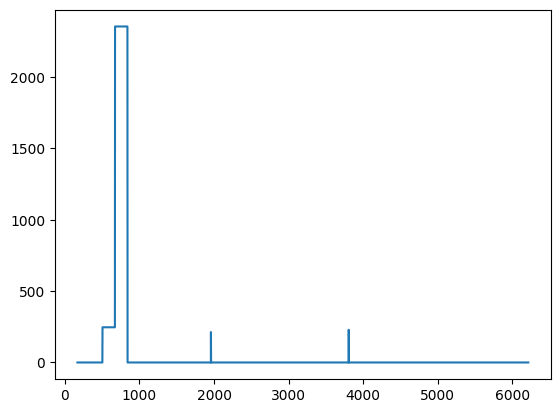

In [7]:
cont_vehicles['vehicle_count'].plot()

In [2]:
from pandas import Grouper
import pandas as pd
from trafficdata.core.trafficmeasurement import replace_min_plateau_using_gauss

dataPath = "/home/marcosperrude/Documents/LCQAR/BRAVES/Traffic"
filename = dataPath +'/inputs/analysisoutputVKT/Anitápolis/prelim_results_Anitápolis_2025-07-01_to_2025-07-01-23_rev2.parquet'
td = trafficdata.read_parquet(
            filename)


# Obtendo dados agrupados por dia, numa média horária
daily_group = td.count_vehicles(
    # road_id,
    grouper=Grouper(
        key='datetime',
        freq='1H'  # Daily frequency
    )
)

vehicle_count_df_weekly = replace_min_plateau_using_gauss(
    daily_group,
    sigma=1,
    set_plateau_to_min=True
    )


In [3]:
vehicle_count_df_weekly.to_csv('contagem_anitapolis_v0p2p5.csv')

<Axes: >

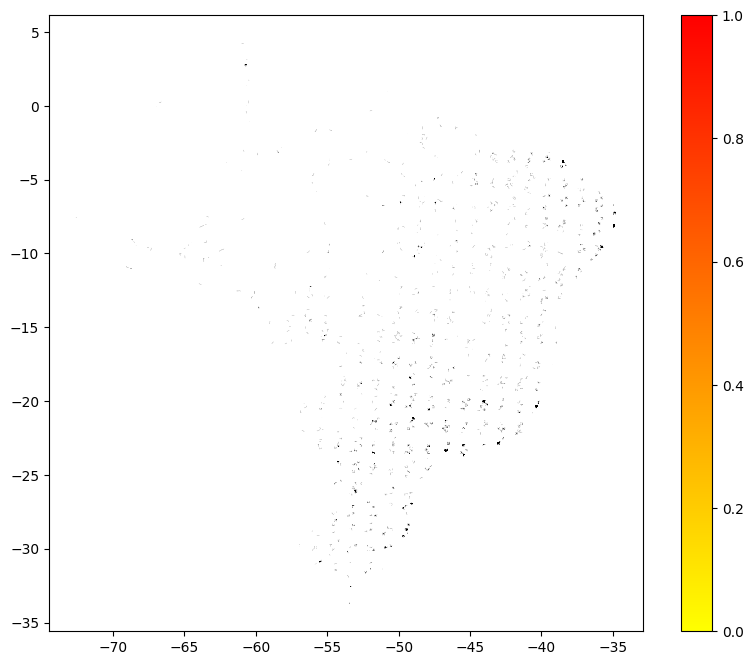

In [12]:
import matplotlib.pyplot as plt
# Plotting map
traffic_example = td.loc[td.datetime == '2025-06-28 7:00:00']

traffic_example['v_inst_per_v_freeflow'] = traffic_example.eval(
    '1 - (traffic_level / inferred_freeflow_speed)'
).astype('float')

traffic_example.explore(
    column='v_inst_per_v_freeflow',
    cmap='autumn_r',
    tiles='CartoDB dark_matter')





## Obtendo e visualizando densidade de veículos no trecho

Vamos usar a ponte Colombo Salles, cujo identificador do OpenStreetMaps
(osm_id) é 35893655, para demonstrar a análise da densidade de carros por hora.


In [9]:
# Definindo id da estrada
road_id = 35893655

# Obtendo dados agrupados por dia, numa média horária
daily_group = td.count_vehicles(
    road_id
)

daily_group.rename_axis(['weekday', 'hour'], inplace=True)

daily_group

osm_id  vehicle_count
weekday hour                           
0       0     35893655.0    4824.269642
        1     35893655.0    4824.269642
        2     35893655.0    4824.269642
        3     35893655.0    4824.269642
        4     35893655.0    4824.269642
...                  ...            ...
6       19    35893655.0    4824.269642
        20    35893655.0    4824.269642
        21    35893655.0    4824.269642
        22    35893655.0    4824.269642
        23    35893655.0    4824.269642

[168 rows x 2 columns]

### Criando uma saída de dados para estimativa de emissão por ressuspensão

SchemaError: column 'traffic_level' not in dataframe. Columns in dataframe: ['highway', 'name', 'osm_id', 'lanes', 'maxspeed', 'oneway', 'lanes:bus', 'lanes:backward', 'lanes:forward', 'maxspeed:backward', 'maxspeed:forward', 'maxspeed:practical', 'geometry', 'road_type', 'traffic_road_coverage', 'road_category', 'road_subcategory', 'datetime', 'slice_length', 'road_closure', 'vehicle_density_factor', 'flow', 'inferred_freeflow_speed', 'vehicle_count', 'road_length', 'vkt_per_hour', 'surface', 'average_daily_vehicle_count']

In [90]:
vehicle_count_df_weekly['vehicle_count']

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
             ...    
103397           0.0
103398           0.0
103399    981.511982
103400           0.0
103401           0.0
Name: vehicle_count, Length: 103402, dtype: Float64

In [4]:
from pandas import Grouper
import pandas as pd
from trafficdata.core.trafficmeasurement import replace_min_plateau_using_gauss

# Definindo id da estrada
#road_id = 35893655

# Obtendo dados agrupados por dia, numa média horária
daily_group = td.count_vehicles(
    # road_id,
    grouper=Grouper(
        key='datetime',
        freq='1H'  # Daily frequency
    )
)

vehicle_count_df_weekly = replace_min_plateau_using_gauss(
    daily_group,
    sigma=1,
    set_plateau_to_min=True
    )

vehicle_count_df_weekly['road_length'] = vehicle_count_df_weekly.osm_id.apply(lambda x: td.get_road_length(x).slice_length)  # td.get_road_length(road_id)
vehicle_count_df_weekly['vkt_per_hour'] = (
    vehicle_count_df_weekly['vehicle_count'] * vehicle_count_df_weekly['road_length']
)

vehicle_count_df_weekly['surface'] = td.surface.iloc[:]

# vehicle_count_df_weekly['avg_traffic_level'] = 
td_traffic_level = td.get_values_aggregated(
    values_headers='traffic_level',
    grouper=pd.Grouper(key= 'datetime', freq='1H'),
    operation='mean'
).reset_index(drop=False)

td_traffic_level = td_traffic_level.rename(columns={'traffic_level': 'avg_traffic_level'})

vehicle_count_df_weekly = vehicle_count_df_weekly.merge(
    td_traffic_level,  
    on=['osm_id', 'datetime'],       
    how='left'                       
)

td_bruno = td.merge(
    vehicle_count_df_weekly,  
    on=['osm_id', 'datetime'],       
    how='left'                       
)

td_bruno['average_daily_vehicle_count'] = td_bruno['vehicle_count'].astype(float).sum(skipna=True)


KeyboardInterrupt: 

In [36]:
td_bruno['average_daily_vehicle_count'] = td_bruno['vehicle_count'].astype(float).sum(skipna=True)


In [37]:
td_bruno

,highway,name,osm_id,lanes,maxspeed,oneway,surface_x,lanes:bus,lanes:backward,lanes:forward,...,road_closure,vehicle_density_factor,flow,inferred_freeflow_speed,vehicle_count,road_length,vkt_per_hour,surface_y,avg_traffic_level,average_daily_vehicle_count
0,secondary,Estrada Caminho dos Açores,76938760.0,2,<NA>,NaN,asphalt,<NA>,<NA>,<NA>,...,NaN,0.0,0.0,37,0.0,804.736211,0.0,asphalt,37.0,3.286316e+06
1,secondary,Estrada Caminho dos Açores,76938760.0,2,<NA>,NaN,asphalt,<NA>,<NA>,<NA>,...,NaN,0.0,0.0,37,0.0,804.736211,0.0,asphalt,37.0,3.286316e+06
2,secondary,Estrada Haroldo Soares Glavan,76938746.0,2,40,NaN,asphalt,<NA>,<NA>,<NA>,...,NaN,0.009807,0.372678,39,299.71127,877.388288,262963.158241,asphalt,38.2,3.286316e+06
3,secondary,Estrada Haroldo Soares Glavan,76938746.0,2,40,NaN,asphalt,<NA>,<NA>,<NA>,...,NaN,0.0,0.0,39,299.71127,877.388288,262963.158241,asphalt,38.2,3.286316e+06
4,secondary,Estrada Haroldo Soares Glavan,973339901.0,2,40,NaN,asphalt,<NA>,<NA>,<NA>,...,NaN,0.010014,0.370512,38,125.729195,125.005495,15716.840267,asphalt,37.666667,3.286316e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7978,residential,None,311571176.0,<NA>,<NA>,yes,NaN,<NA>,<NA>,<NA>,...,None,0.0,0.0,38,0.0,29.779383,0.0,NaN,38.0,3.286316e+06
7979,secondary,Estrada Haroldo Soares Glavan,973339893.0,2,40,NaN,asphalt,<NA>,<NA>,<NA>,...,None,0.0,0.0,38,0.0,355.576880,0.0,asphalt,38.0,3.286316e+06
7980,secondary,Estrada Haroldo Soares Glavan,973339895.0,2,40,NaN,asphalt,<NA>,<NA>,<NA>,...,None,0.0,0.0,39,95.008277,864.965830,82178.912808,asphalt,38.75,3.286316e+06
7981,secondary,Estrada Haroldo Soares Glavan,973339881.0,2,40,NaN,asphalt,<NA>,<NA>,<NA>,...,None,0.0,0.0,38,0.0,456.119880,0.0,asphalt,38.0,3.286316e+06


In [25]:
td_traffic_level

,osm_id,datetime,avg_traffic_level
0,1.049272e+07,2025-07-01 06:00:00,71.0
1,1.049272e+07,2025-07-01 07:00:00,71.0
2,1.049272e+07,2025-07-01 06:00:00,80.0
3,1.049272e+07,2025-07-01 07:00:00,80.0
4,1.049276e+07,2025-07-01 06:00:00,54.0
...,...,...,...
8617,1.371658e+09,2025-07-01 07:00:00,25.0
8618,1.371658e+09,2025-07-01 06:00:00,30.0
8619,1.371658e+09,2025-07-01 07:00:00,30.0
8620,1.376095e+09,2025-07-01 06:00:00,34.0


In [20]:

td_bruno = td.merge(
    vehicle_count_df_weekly,  
    on=['osm_id', 'datetime'],       
    how='left'                       
)

In [21]:
td_bruno.

,highway,name,osm_id,lanes,maxspeed,oneway,surface_x,lanes:bus,lanes:backward,lanes:forward,...,road_closure,vehicle_density_factor,flow,inferred_freeflow_speed,traffic_level_y,vehicle_count,road_length,vkt_per_hour,surface_y,traffic_level
0,secondary,Estrada Caminho dos Açores,76938760.0,2,<NA>,NaN,asphalt,<NA>,<NA>,<NA>,...,NaN,0.0,0.0,37,37.0,0.0,804.736211,0.0,asphalt,37.0
1,secondary,Estrada Caminho dos Açores,76938760.0,2,<NA>,NaN,asphalt,<NA>,<NA>,<NA>,...,NaN,0.0,0.0,37,37.0,0.0,804.736211,0.0,asphalt,37.0
2,secondary,Estrada Haroldo Soares Glavan,76938746.0,2,40,NaN,asphalt,<NA>,<NA>,<NA>,...,NaN,0.009807,0.372678,39,38.2,299.71127,877.388288,262963.158241,asphalt,38.2
3,secondary,Estrada Haroldo Soares Glavan,76938746.0,2,40,NaN,asphalt,<NA>,<NA>,<NA>,...,NaN,0.0,0.0,39,38.2,299.71127,877.388288,262963.158241,asphalt,38.2
4,secondary,Estrada Haroldo Soares Glavan,973339901.0,2,40,NaN,asphalt,<NA>,<NA>,<NA>,...,NaN,0.010014,0.370512,38,37.666667,125.729195,125.005495,15716.840267,asphalt,37.666667


In [91]:
# vehicle_count_df_weekly['datetime'] = vehicle_count_df_weekly['datetime'] - pd.Timedelta(hours=3)

In [17]:
# vehicle_count_df_weekly['avg_traffic_level'] = 
td_traffic_level = td.get_values_aggregated(
    values_headers='traffic_level',
    grouper=pd.Grouper(key= 'datetime', freq='1H'),
    operation='mean'
).reset_index(drop=False)

In [32]:
td_bruno_2.columns

Index(['highway', 'name', 'osm_id', 'lanes', 'maxspeed', 'oneway', 'lanes:bus',
       'lanes:backward', 'lanes:forward', 'maxspeed:backward',
       'maxspeed:forward', 'maxspeed:practical', 'geometry', 'road_type',
       'traffic_road_coverage', 'road_category', 'road_subcategory',
       'datetime', 'slice_length', 'road_closure', 'vehicle_density_factor',
       'flow', 'inferred_freeflow_speed', 'vehicle_count', 'road_length',
       'vkt_per_hour', 'surface', 'avg_traffic_level'],
      dtype='object')

In [25]:
td_bruno_2 = td_bruno_2.merge(
    td_traffic_level,  
    on=['osm_id', 'datetime'],       
    how='left'                       
)

In [22]:

vehicle_count_df_weekly['avg_traffic_level'] = td.get_values_aggregated_by_road_id(
     road_id, 'traffic_level', grouper=Grouper(key='datetime', freq='1D')
     )['traffic_level']

AttributeError: 'GeoDataFrame' object has no attribute 'get_values_aggregated_by_road_id'

In [29]:
td_bruno_2 = td_bruno_2.rename(columns={'traffic_level': 'avg_traffic_level'})

In [107]:
td_bruno.columns

Index(['highway', 'name', 'osm_id', 'lanes', 'maxspeed', 'oneway', 'lanes:bus',
       'lanes:backward', 'lanes:forward', 'maxspeed:backward',
       'maxspeed:forward', 'maxspeed:practical', 'geometry', 'road_type',
       'traffic_road_coverage', 'road_category', 'road_subcategory',
       'datetime', 'slice_length', 'road_closure', 'vehicle_density_factor',
       'flow', 'inferred_freeflow_speed', 'vehicle_count', 'road_length',
       'vkt_per_hour', 'surface'],
      dtype='object')

In [35]:
# Remover a coluna 'geometry' do DataFrame
vehicle_count_df_weekly = vehicle_count_df_weekly.drop(columns=['geometry'])


In [104]:
vehicle_count_df_weekly

,osm_id,datetime,vehicle_count,road_length,vkt_per_hour,surface
0,1.049272e+07,2025-06-30 21:00:00,NaN,711.024111,NaN,asphalt
1,1.049272e+07,2025-06-30 22:00:00,NaN,711.024111,NaN,asphalt
2,1.049272e+07,2025-06-30 23:00:00,NaN,711.024111,NaN,asphalt
3,1.049272e+07,2025-07-01 00:00:00,NaN,711.024111,NaN,NaN
4,1.049272e+07,2025-07-01 01:00:00,NaN,711.024111,NaN,asphalt
...,...,...,...,...,...,...
103397,1.376095e+09,2025-07-01 16:00:00,0.0,11.708807,0.0,NaN
103398,1.376095e+09,2025-07-01 17:00:00,0.0,11.708807,0.0,NaN
103399,1.376095e+09,2025-07-01 18:00:00,981.511982,11.708807,11492.334659,asphalt
103400,1.376095e+09,2025-07-01 19:00:00,0.0,11.708807,0.0,asphalt


In [36]:
td = td.merge(
    vehicle_count_df_weekly,  
    on=['osm_id', 'datetime'],  
    how='left'                       
)

In [103]:
td = td.drop(columns={'traffic_level','surface'})


In [48]:
td.columns

Index(['highway', 'name', 'osm_id', 'lanes', 'maxspeed', 'oneway', 'lanes:bus',
       'lanes:backward', 'lanes:forward', 'maxspeed:backward',
       'maxspeed:forward', 'maxspeed:practical', 'geometry', 'road_type',
       'traffic_road_coverage', 'road_category', 'road_subcategory',
       'datetime', 'slice_length', 'road_closure', 'vehicle_density_factor',
       'flow', 'inferred_freeflow_speed', 'vehicle_count', 'road_length',
       'vkt_per_hour', 'surface_y', 'traffic_level_y'],
      dtype='object')

In [ ]:

vehicle_count_df_weekly['surface'] = vehicle_count_df_weekly.surface.iloc[:

AttributeError: 'GeoDataFrame' object has no attribute 'get_values_aggregated_by_road_id'

In [75]:
vehicle_count_df_weekly

,osm_id,datetime,vehicle_count,road_length,vkt_per_hour,surface,traffic_level
0,1.049272e+07,2025-06-30 21:00:00,NaN,711.024111,NaN,asphalt,<NA>
1,1.049272e+07,2025-06-30 22:00:00,NaN,711.024111,NaN,asphalt,<NA>
2,1.049272e+07,2025-06-30 23:00:00,NaN,711.024111,NaN,asphalt,<NA>
3,1.049272e+07,2025-07-01 00:00:00,NaN,711.024111,NaN,NaN,71.0
4,1.049272e+07,2025-07-01 01:00:00,NaN,711.024111,NaN,asphalt,71.0
...,...,...,...,...,...,...,...
103397,1.376095e+09,2025-07-01 16:00:00,0.0,11.708807,0.0,NaN,34.0
103398,1.376095e+09,2025-07-01 17:00:00,0.0,11.708807,0.0,NaN,34.0
103399,1.376095e+09,2025-07-01 18:00:00,981.511982,11.708807,11492.334659,asphalt,34.0
103400,1.376095e+09,2025-07-01 19:00:00,0.0,11.708807,0.0,asphalt,34.0


In [79]:
td['vehicle_count'].sort_values()

267832     0.0
267800     0.0
267801     0.0
267811     0.0
267812     0.0
          ... 
544043    <NA>
544044    <NA>
544045    <NA>
544046    <NA>
544047    <NA>
Name: vehicle_count, Length: 544048, dtype: Float64

In [137]:
    td_bruno['average_daily_vehicle_count']

0         8.262876e+07
1         8.262876e+07
2         8.262876e+07
3         8.262876e+07
4         8.262876e+07
              ...     
192713    8.262876e+07
192714    8.262876e+07
192715    8.262876e+07
192716    8.262876e+07
192717    8.262876e+07
Name: average_daily_vehicle_count, Length: 192718, dtype: float64

In [33]:
td_bruno_2['avg_traffic_level']

0          32.0
1          32.0
2          32.0
3          47.0
4          44.6
          ...  
192713     38.0
192714     38.0
192715    38.75
192716     38.0
192717     39.0
Name: avg_traffic_level, Length: 192718, dtype: Float64

In [39]:
td_bruno_2.average_daily_vehicle_count

0         8.826799e+07
1         8.826799e+07
2         8.826799e+07
3         8.826799e+07
4         8.826799e+07
              ...     
192713    8.826799e+07
192714    8.826799e+07
192715    8.826799e+07
192716    8.826799e+07
192717    8.826799e+07
Name: average_daily_vehicle_count, Length: 192718, dtype: float64

In [71]:
td['vehicle_count'].sum(skipna=True) * 24

NameError: name 'skipna' is not defined

In [139]:
td_bruno

,highway,name,osm_id,lanes,maxspeed,oneway,lanes:bus,lanes:backward,lanes:forward,maxspeed:backward,...,slice_length,road_closure,vehicle_density_factor,flow,inferred_freeflow_speed,vehicle_count,road_length,vkt_per_hour,surface,average_daily_vehicle_count
0,tertiary,Avenida Antônio Borges dos Santos,95425125.0,2,50,NaN,<NA>,<NA>,<NA>,NaN,...,38.202069,NaN,0.0,0.0,32,0.0,462.594143,0.0,NaN,8.262876e+07
1,tertiary,Avenida Antônio Borges dos Santos,95425125.0,2,50,NaN,<NA>,<NA>,<NA>,NaN,...,419.480314,NaN,0.0,0.0,32,0.0,462.594143,0.0,NaN,8.262876e+07
2,tertiary,Avenida Antônio Borges dos Santos,95425125.0,2,50,NaN,<NA>,<NA>,<NA>,NaN,...,4.911760,NaN,0.0,0.0,32,0.0,462.594143,0.0,NaN,8.262876e+07
3,service,None,434301981.0,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,...,22.127003,NaN,0.0,0.0,47,0.0,22.127003,0.0,asphalt,8.262876e+07
4,secondary,"Rodovia ""Seu Chico"" Francisco Thomaz dos Santos",177696977.0,<NA>,60,no,<NA>,<NA>,<NA>,NaN,...,0.452655,NaN,0.0,0.0,47,324.001521,1115.106085,361296.068009,asphalt,8.262876e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192713,residential,None,311571176.0,<NA>,<NA>,yes,<NA>,<NA>,<NA>,NaN,...,29.779383,None,0.0,0.0,38,<NA>,NaN,<NA>,NaN,8.262876e+07
192714,secondary,Estrada Haroldo Soares Glavan,973339893.0,2,40,NaN,<NA>,<NA>,<NA>,NaN,...,355.576880,None,0.0,0.0,38,<NA>,NaN,<NA>,NaN,8.262876e+07
192715,secondary,Estrada Haroldo Soares Glavan,973339895.0,2,40,NaN,<NA>,<NA>,<NA>,NaN,...,246.366810,None,0.0,0.0,39,<NA>,NaN,<NA>,NaN,8.262876e+07
192716,secondary,Estrada Haroldo Soares Glavan,973339881.0,2,40,NaN,<NA>,<NA>,<NA>,NaN,...,456.119880,None,0.0,0.0,38,<NA>,NaN,<NA>,NaN,8.262876e+07


In [40]:
td_bruno_2.to_parquet(
    './outputs/bruno_florianopolis_2025_7_1_0_23.parquet', 
    index=False
)

In [23]:
from pandas import Grouper
import pandas as pd
from trafficdata.core.trafficmeasurement import replace_min_plateau_using_gauss

# Definindo id da estrada
#road_id = 35893655

# Obtendo dados agrupados por dia, numa média horária
daily_group = td.count_vehicles(
    # road_id,
    grouper=Grouper(
        key='datetime',
        freq='1H'  # Daily frequency
    )
)

vehicle_count_df_weekly = replace_min_plateau_using_gauss(
    daily_group,
    sigma=1,
    set_plateau_to_min=True
    )

# Corrigindo datetime
vehicle_count_df_weekly['datetime'] = vehicle_count_df_weekly['datetime'] - pd.Timedelta(hours=3)
vehicle_count_df_weekly

# Multiplicando pelas 24 horas para obter o total diário
# daily_group['average_daily_vehicle_count'] = daily_group['vehicle_count'] * 24
vehicle_count_df_weekly['road_length'] = vehicle_count_df_weekly.osm_id.apply(lambda x: td.get_road_length(x).slice_length)  # td.get_road_length(road_id)
vehicle_count_df_weekly['vkt_per_hour'] = (
    vehicle_count_df_weekly['vehicle_count'] * vehicle_count_df_weekly['road_length']
)

# Adicionando outras informações relevantes
# daily_group['surface'] = td.loc[td.osm_id == road_id].surface.iloc[0]
# daily_group['avg_traffic_level'] = td.get_values_aggregated_by_road_id(
#     road_id, 'traffic_level', grouper=Grouper(key='datetime', freq='1D')
#     )['traffic_level']
# daily_group_geom, daily_group_geom_crs = td.get_road_geometry(road_id)
# daily_group['geometry'] = daily_group_geom


# Adding metadata information
vehicle_count_df_weekly.attrs = {
    'vehicle_count': 'Average hourly vehicle count [vehicles / hour]',
    'average_daily_vehicle_count': 'Average daily vehicle count [vehicles / day]',
    'road_length': 'Road length [meters]',
    'vkt_per_hour': 'Vehicle Kilometers Traveled per hour [vehicles * km / hour]',
    'surface': "Road surface type ['asphalt', 'paving_stones', 'compacted', None, 'unpaved', 'sett', "
       "'paved', 'cobblestone', 'metal', 'ground', 'gravel', 'dirt',"
       "'concrete:plates']",
    'avg_traffic_level': 'Average traffic level [km / hour]'
}

vehicle_count_df_weekly = pd.DataFrame(
    vehicle_count_df_weekly,
    # geometry='geometry',
    # crs=daily_group_geom_crs
)

vehicle_count_df_weekly

KeyboardInterrupt: 

In [37]:
from trafficdata.core.trafficmeasurement import get_aggregate_weekday_hourly_vehicle_count

vehicle_count_df_weekly_final = get_aggregate_weekday_hourly_vehicle_count(
    vehicle_count_df_weekly,
    maxmin=True
)

,osm_id,weekday,hour,vehicle_count,road_length,vkt_per_hour,vehicle_count_max,vehicle_count_min
0,1.049272e+07,0,21,NaN,711.024111,NaN,-inf,inf
1,1.049272e+07,0,22,NaN,711.024111,NaN,-inf,inf
2,1.049272e+07,0,23,NaN,711.024111,NaN,-inf,inf
3,1.049272e+07,1,0,NaN,711.024111,NaN,-inf,inf
4,1.049272e+07,1,1,NaN,711.024111,NaN,-inf,inf
...,...,...,...,...,...,...,...,...
103397,1.376095e+09,1,16,0.0,11.708807,0.0,0.0,0.0
103398,1.376095e+09,1,17,0.0,11.708807,0.0,0.0,0.0
103399,1.376095e+09,1,18,981.511982,11.708807,11492.334659,981.511982,981.511982
103400,1.376095e+09,1,19,0.0,11.708807,0.0,0.0,0.0


In [7]:
import pandas as pd

saob = pd.read_csv('./inputs/analysisoutputVKT/São Bonifácio/vehicle_count_df_weekly_final.csv')
saob

,osm_id,weekday,hour,vehicle_count,road_length,vkt_per_hour,vehicle_count_max,vehicle_count_min
0,3.161446e+07,0,0,NaN,3782.638064,NaN,-inf,inf
1,3.161446e+07,0,1,NaN,3782.638064,NaN,-inf,inf
2,3.161446e+07,0,2,NaN,3782.638064,NaN,-inf,inf
3,3.161446e+07,0,3,NaN,3782.638064,NaN,-inf,inf
4,3.161446e+07,0,4,NaN,3782.638064,NaN,-inf,inf
...,...,...,...,...,...,...,...,...
4531,1.340539e+09,6,19,723.531239,299.762193,216887.311081,723.531239,723.531239
4532,1.340539e+09,6,20,723.531239,299.762193,216887.311081,723.531239,723.531239
4533,1.340539e+09,6,21,723.531239,299.762193,216887.311081,723.531239,723.531239
4534,1.340539e+09,6,22,723.531239,299.762193,216887.311081,723.531239,723.531239


In [4]:

for i in range(17):
    
    cidade = pd.read_csv('./inputs/analysisoutputVKT/Florianópolis/vehicle_count_df_weekly_final.csv')
    flori_day = florianopolis.groupby("weekday")["vkt_per_hour"].sum().reset_index(name="vkt_dia")
    flori_day['vkt_dia'].sum() * 52 / 1000

NameError: name 'florianopolis' is not defined

In [31]:
import os
import pandas

cidades = [d for d in os.listdir('./inputs/analysisoutputVKT') if os.path.isdir(os.path.join('./inputs/analysisoutputVKT', d))]
resultados = []

for cidade in cidades:
    mun = pd.read_csv(f'./inputs/analysisoutputVKT/{cidade}/vehicle_count_df_weekly_final.csv')
    vkt_dia = mun.groupby("weekday")["vkt_per_hour"].sum().reset_index(name="vkt_dia")
    vkt_anual = vkt_dia['vkt_dia'].sum() * 52 / 1000
    resultados.append({"cidade": cidade, "VKT_anual": vkt_anual})

vktGrandeFLori = pd.DataFrame(resultados)

vktGrandeFLori.to_csv('./outputs/vkt_anual_traffic.csv', index=False)
vktGrandeFLori

,cidade,VKT_anual
0,São Bonifácio,1.067674e+08
1,Anitápolis,2.107730e+08
2,Florianópolis,2.254350e+09
3,São Pedro de Alcântara,8.546926e+07
4,Governador Celso Ramos,1.482962e+08
5,Antônio Carlos,1.964847e+07
6,Alfredo Wagner,2.201971e+07
7,São José,7.690640e+08
8,Biguaçu,1.609479e+08
9,Paulo Lopes,4.174983e+07


In [133]:
td_bruno['vehicle_count'].dtypes


Float64Dtype()

In [14]:
osm_id_test = vehicle_count_df_weekly_final.iloc[3000].osm_id

for i in range(6):
    vehicle_count_df_weekly_final.loc[
        (vehicle_count_df_weekly_final.osm_id == osm_id_test) & \
        (vehicle_count_df_weekly_final.weekday == i), ['hour', 'vehicle_count']].set_index('hour').plot()

AttributeError: 'GeoDataFrame' object has no attribute 'weekday'

In [38]:
daily_group_2

,osm_id,vehicle_count
0,1.049272e+07,NaN
1,1.049272e+07,NaN
2,1.049272e+07,NaN
3,1.049272e+07,NaN
4,1.049272e+07,NaN
...,...,...
206909,1.376095e+09,0.0
206910,1.376095e+09,737.963621
206911,1.376095e+09,1025.288131
206912,1.376095e+09,945.024496


In [37]:

daily_group_2 = daily_group_2.drop(columns='datetime')

daily_group_2['road_length'] = daily_group_2.osm_id.apply(lambda x: td.get_road_length(x).slice_length) / 1000  # td.get_road_length(road_id)

daily_group_2 = daily_group_2.groupby(by='osm_id').sum().reset_index(drop=False)

daily_group_2['vkt_per_day'] = (
    daily_group_2['vehicle_count'] * daily_group_2['road_length'] * 24
)

daily_group_2

KeyboardInterrupt: 

<Axes: >

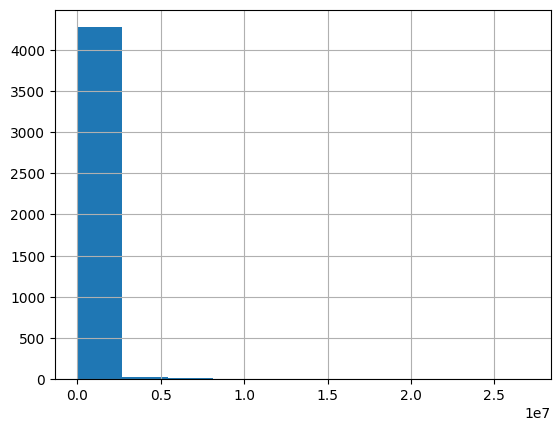

In [67]:
daily_group_2.vkt_per_day.hist()

In [79]:
daily_group_2.sort_values(by="vehicle_count", ascending=False).head(50)

,osm_id,vehicle_count,road_length,vkt_per_day
0,1.049272e+07,NaN,5.214756,NaN
3102,9.640250e+08,NaN,0.000000,NaN
1391,2.059708e+08,187675.410636,0.000000,0.0
1392,2.059708e+08,186169.342387,0.000000,0.0
2269,5.659123e+08,183238.976126,0.000000,0.0
1203,1.773182e+08,176108.76196,0.000000,0.0
2361,6.570763e+08,164006.622315,0.000000,0.0
1055,1.667444e+08,162732.071217,0.000000,0.0
858,1.546872e+08,153864.338573,0.000000,0.0
722,1.340093e+08,152423.187559,0.000000,0.0


,osm_id,vehicle_count,road_length,vkt_per_day
0,10492722.0,NaN,5.214756,NaN
3102,964024992.0,NaN,0.000000,NaN
1391,205970771.0,187675.410636,0.000000,0.0
1392,205970772.0,186169.342387,0.000000,0.0
2269,565912279.0,183238.976126,0.000000,0.0
1203,177318239.0,176108.76196,0.000000,0.0
2361,657076308.0,164006.622315,0.000000,0.0
1055,166744426.0,162732.071217,0.000000,0.0
858,154687225.0,153864.338573,0.000000,0.0
722,134009339.0,152423.187559,0.000000,0.0


In [83]:
daily_group_2.iloc[33,0]

np.float64(35161005.0)

In [72]:
daily_group_2.iloc[2,0]

np.float64(205970771.0)

In [43]:
example_value = daily_group.iloc[1,0]

daily_group.loc[daily_group.osm_id == example_value]

,osm_id,datetime,vehicle_count,road_length,vkt_per_hour
1,10492725.0,2025-07-01,49148.323684,287.528433,14131540.503812


In [63]:
daily_group_2.loc[daily_group_2.osm_id == example_value]

,osm_id,vehicle_count,road_length,vkt_per_day
1,10492725.0,11937.359213,4.813574,1379072.772462


In [66]:
daily_group_2['vkt_per_day'].fillna(0).sum()



<NA>

In [65]:
daily_group_2['vkt_per_day'].astype('float64').sum()

np.float64(330544185.4650121)

In [80]:
td.count_vehicles(
    # road_id,
    grouper=Grouper(
        key='datetime',
        freq='1D'  # Daily frequency
    )
).head(50)

,osm_id,datetime,vehicle_count
0,10492722.0,2025-07-01,NaN
1,10492725.0,2025-07-01,49148.323684
2,10492763.0,2025-07-01,111096.216241
3,10492764.0,2025-07-01,18285.037553
4,10594905.0,2025-07-01,0.0
5,35130332.0,2025-07-01,23980.920243
6,35130529.0,2025-07-01,43983.58477
7,35130530.0,2025-07-01,31546.624334
8,35130531.0,2025-07-01,6350.147274
9,35131710.0,2025-07-01,20014.612228


In [81]:
td.get_road_length()

TypeError: TrafficData.get_road_length() missing 1 required positional argument: 'road_id'

In [13]:
# Exportando
if not Path('vehicle_cvehicle_count_daily-{start_date}_to_{end_date}.csv').exists():
    # daily_group.to_csv(f'vehicle_count_daily-{start_date}_to_{end_date}.csv')
    daily_group.to_parquet(f'vehicle_count_daily-{start_date}_to_{end_date}_rev1.parquet')